In [2]:
import ctypes
try:
    ctypes.CDLL('/home/jupyter/cuda-11.7/lib64/libcudart.so')
    print("Successfully loaded libcudart.so")
except OSError as e:
    print("Error loading libcudart.so:", e)

try:
    ctypes.CDLL('/home/jupyter/cuda-11.7/lib64/libcudnn.so')
    print("Successfully loaded libcudnn.so")
except OSError as e:
    print("Error loading libcudnn.so:", e)


Successfully loaded libcudart.so
Successfully loaded libcudnn.so


In [3]:
import os
import tensorflow as tf
os.environ['PATH'] = os.environ.get('PATH', '') + ':/home/jupyter/cuda-11.7/bin'
os.environ['LD_LIBRARY_PATH'] = os.environ.get('LD_LIBRARY_PATH', '') + ':/home/jupyter/cuda-11.7/lib64'

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2024-05-27 16:46:42.592280: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 16:46:43.987733: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.12.0
Num GPUs Available:  1


2024-05-27 16:46:47.575566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 16:46:47.907868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 16:46:47.913640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
!nvidia-smi

Mon May 27 16:37:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       On  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      5MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.12.0
Num GPUs Available:  1


In [5]:
pip install librosa

  Using cached librosa-0.10.2.post1-py3-none-any.whl.metadata (8.6 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached soundfile-0.12.1-py2.py3-none-manylinux_2_31_x86_64.whl.metadata (14 kB)
  Using cached pooch-1.8.1-py3-none-any.whl.metadata (9.5 kB)
  Using cached soxr-0.3.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 kB)
Using cached librosa-0.10.2.post1-py3-none-any.whl (260 kB)
Using cached audioread-3.0.1-py3-none-any.whl (23 kB)
Using cached pooch-1.8.1-py3-none-any.whl (62 kB)
Using cached soundfile-0.12.1-py2.py3-none-manylinux_2_31_x86_64.whl (1.2 MB)
Using cached soxr-0.3.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from spectrograms import *
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import pandas as pd

### Tests on how to train a CNN using the data we have 775*308px

In [7]:
df = pd.read_csv('train_metadata.csv')
df['filepath'] = 'train_audio/' + df.filename
df['target'] = df.primary_label.map(CFG.name2label)
df['filename'] = df.filepath.map(lambda x: x.split('/')[-1])
df['xc_id'] = df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

In [8]:
train_df.head(3)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target,xc_id
8932,eaywag1,[],[''],43.3479,4.7934,Motacilla flava,Western Yellow Wagtail,Stanislas Wroza,Creative Commons Attribution-NonCommercial-Sha...,2.0,https://xeno-canto.org/790724,XC790724.ogg,train_audio/eaywag1/XC790724.ogg,53,XC790724
7578,comsan,[],['nocturnal flight call'],43.5352,-1.4475,Actitis hypoleucos,Common Sandpiper,Frédéric Cazaban,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/644516,XC644516.ogg,train_audio/comsan/XC644516.ogg,44,XC644516
1918,bkskit1,[],"['call', 'female', 'flight call', 'male']",37.3823,-6.1363,Elanus caeruleus,Black-winged Kite,José Carlos Sires,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/353823,XC353823.ogg,train_audio/bkskit1/XC353823.ogg,13,XC353823


In [9]:
df["target"].value_counts()

target
181    500
105    500
107    500
37     500
39     500
      ... 
16       6
178      6
119      5
5        5
92       5
Name: count, Length: 182, dtype: int64

In [10]:
target_counts = df['target'].value_counts()
print(len(target_counts[target_counts == 500]))

22


In [11]:
def create_model(input_shape_img, num_classes):
    img_input = Input(shape=input_shape_img, name='img_input')
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=img_input, outputs=x)
    
    return model

In [12]:
input_shape_img_rgb = (*CFG.img_size, 3)  # for RGB images
input_shape_img_bw = (*CFG.img_size, 1)  # for grayscale images
input_shape_meta = (2,)  # for latitude and longitude
num_classes = CFG.num_classes

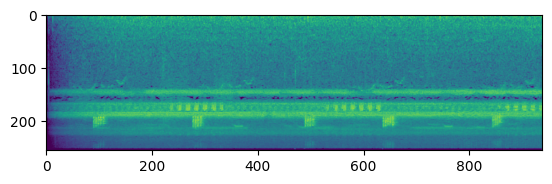

In [13]:
img_test = preprocess_audio('train_audio/asbfly/XC305518.ogg', rgb=False)
plt.imshow(img_test, cmap='viridis')
plt.show()

In [14]:
model = create_model(input_shape_img_bw, num_classes)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

2024-05-27 16:50:07.012202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 16:50:07.015678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 16:50:07.018721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [16]:
img_test.shape

(256, 938)

In [17]:
input_shape_img_bw

(256, 938, 1)

In [18]:
# Verify the generator
batch_size = CFG.batch_size
train_generator = data_generator(train_df, batch_size, img_size=CFG.img_size, rgb=False)
test_generator = data_generator(test_df, batch_size, img_size=CFG.img_size, rgb=False)

for _ in range(1):
    img_batch, target_batch = next(test_generator)
    print(f'Image batch shape: {img_batch.shape}')
    print(f'Target batch shape: {target_batch.shape}')
    break


Image batch shape: (64, 256, 938, 1)
Target batch shape: (64,)


In [19]:
model.fit(train_generator, steps_per_epoch=len(train_df) // CFG.batch_size, epochs=CFG.epochs)

Epoch 1/3


2024-05-27 16:51:32.750870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-05-27 16:51:35.383897: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:417] Loaded runtime CuDNN library: 8.2.4 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2024-05-27 16:51:35.385435: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops_fused_impl.h:625 : UNIMPLEMENTED: DNN library is not found.
2024-05-27 16:51:35.385510: I tensorflow/core/common_runtime/ex

UnimplementedError: Graph execution error:

Detected at node 'model/conv2d/Relu' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1/670747812.py", line 1, in <module>
      model.fit(train_generator, steps_per_epoch=len(train_df) // CFG.batch_size, epochs=CFG.epochs)
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 321, in call
      return self.activation(outputs)
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/home/jupyter/.local/lib/python3.10/site-packages/keras/backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'model/conv2d/Relu'
DNN library is not found.
	 [[{{node model/conv2d/Relu}}]] [Op:__inference_train_function_2035]